# Toy 00: testing toy setting with linear models

HOWTO: run the dataset & model cells, then run either of the solution cells following by the analysis cell.

In [1]:
%load_ext autoreload

# Dataset & model

In [56]:
import torch
from torch import nn

def get_inputs(n=1, size=[5,5]):
    return torch.ones([n, 3] + size)

def get_inputs_cutoffneuron_pixelimage(n=1, size=[5,5]):
    im = torch.ones([n, 3] + size)
    pe = torch.zeros([n, 1] + size)
    pe[:, :, 2, 2] = 1
    return im, pe

def get_inputs_cutoffneuron_discpe(size=[5,5]):
    im = torch.zeros([2, 3] + size)
    im[0, :, 1, 1] = 1
    im[1, :, 3, 3] = 1
    lab = torch.tensor([0, 1]).unsqueeze(1)
    pe = torch.zeros([2, 1] + size)
    pe[:, :, :, :2] = 1
    pe[:, :, :, 3:] = -1
    return im, lab, pe

images = get_inputs()
labels = torch.tensor([0]).unsqueeze(0).repeat(images.size(0), 1)

con_pi_images, con_pi_pe = get_inputs_cutoffneuron_pixelimage()
con_dp_images, con_dp_labels, con_dp_pe = get_inputs_cutoffneuron_discpe()

class SimpleNet(nn.Module):
    def __init__(self, size, pos_emb, bias, solution='c0:image'):
        super().__init__()
        self.solution = solution
        self.pos_emb = pos_emb
        self.bias = nn.Parameter(bias)

    def forward(self, inputs):
        if inputs.shape[0] != 1:
            raise NotImplementedError("Only batch size 1 is supported")
        self.image_in = inputs
        self.pos_emb_in = self.pos_emb
        self.image_in.requires_grad = True
        self.pos_emb_in.requires_grad = True

        x = self.image_in
        y = self.pos_emb_in

        if self.solution == 'c0:image':
            class_0 = x.mean() + (self.bias * 0.).sum()
            class_1 = y.mean() * 0.
        elif self.solution == 'c0:pos':
            class_0 = y.mean() + (self.bias * 0.).sum()
            class_1 = x.mean() * 0.
        elif self.solution == 'c0:bias':
            class_0 = (x.mean() * 0.) + (self.bias).sum()
            class_1 = y.mean() * 0.
        elif self.solution == 'c0:image+noisepos0.1':
            noise = torch.randn_like(y) * 0.1
            class_0 = x.mean() + (y * noise).mean() + (self.bias * 0.).sum()
            class_1 = y.mean() * 0.
        elif self.solution == 'c0:image+noisepos0.5':
            noise = torch.randn_like(y) * 0.5
            class_0 = x.mean() + (y * noise).mean() + (self.bias * 0.).sum()
            class_1 = y.mean() * 0.
        # Toys for debugging problems with nonlinearities
        elif self.solution == 'cutoffneuron:pixelimage':
            cutoffneuron = torch.relu(-x + 2. * y)
            class_0 = cutoffneuron.mean() + (self.bias * 0.).sum()
            # print(cutoffneuron[:,:,0,0].mean(), cutoffneuron[:,:,2,2].mean())
            class_1 = y.mean() * 0.
        elif self.solution == 'cutoffneuron:discpe':
            neuron_im = torch.relu(-0.5 + x)
            # print(neuron_im[0,0])
            cutoffneuron_c0 = torch.relu(neuron_im * y)
            cutoffneuron_c1 = torch.relu(neuron_im * -y)
            class_0 = cutoffneuron_c0.mean() + (self.bias * 0.).sum()
            class_1 = cutoffneuron_c1.mean() + (self.bias * 0.).sum()
            # class_1 = y.mean() * 0.
        else:
            raise NotImplementedError(f"Solution {self.solution} not implemented")

        return torch.stack([class_0, class_1]).unsqueeze(0)

In [37]:
x = get_input()
y = get_input() * 0.
x.requires_grad = True
y.requires_grad = True
gt_probs = torch.tensor([1., 0.])
model = SimpleNet(x.size())
logits = model([x, y])
probs = torch.softmax(logits, dim=0)
loss = torch.nn.functional.cross_entropy(logits, gt_probs)
(-loss).backward()
print(probs, loss)
# print(x * x.grad, y * y.grad)

tensor([0.7311, 0.2689], grad_fn=<SoftmaxBackward0>) tensor(0.3133, grad_fn=<DivBackward1>)


# Analysis

In [3]:
%autoreload
import numpy as np

import training
import utils


def run_debug(seeds, solution, pos_emb, bias, analysis_images, analysis_labels, n_classes, attribution_method='input_gradient_withnegative', aggregate_fn='sum', target='pred_class', ):
    biases = {'bias': [], 'appearance': [], 'position': [], 'relative_position': []}
    biases_withbias = {'bias': [], 'appearance': [], 'position': [], 'relative_position': []}
    cls_biases = {c: {'bias': [], 'appearance': [], 'position': [], 'relative_position': []} for c in range(n_classes)}
    cls_biases_withbias = {c: {'bias': [], 'appearance': [], 'position': [], 'relative_position': []} for c in range(n_classes)}
    models = []
    for seed in seeds:
        torch.manual_seed(seed)
        model = SimpleNet([5, 5], pos_emb.clone(), bias.clone(), solution)

        # Analysis
        n_samples = None
        targets = [target]
        shape = 'scalar'
        patch_size = 1
        attribution_method = 'input_gradient'
        aggregate_fn = 'sum'

        seed_biases, seed_biases_withbias, seed_cls_biases, seed_cls_biases_withbias = \
            utils.toy_all_analyses(model, analysis_images, analysis_labels, n_classes, seed, sources_available=['image', 'pos_emb', 'bias'], attribution_method=attribution_method, aggregate_fn=aggregate_fn, target=target)

        for key in seed_biases:
            biases[key].append(seed_biases[key])
            for c in range(n_classes):
                if c in seed_cls_biases:
                    cls_biases[c][key].append(seed_cls_biases[c][key])

        for key in seed_biases_withbias:
            biases_withbias[key].append(seed_biases_withbias[key])
            for c in range(n_classes):
                if c in seed_cls_biases_withbias:
                    cls_biases_withbias[c][key].append(seed_cls_biases_withbias[c][key])

        models.append(model)

    utils.toy_postprocess_analysis(biases, biases_withbias, cls_biases, cls_biases_withbias, seeds, n_classes, sort_by_appearance=False)

    return models

### "Cut off neuron"

In [58]:
%autoreload

"""
Solution "cutoffneuron:pixelimage" - counterexample to show how saliency does not work for non-linearities
Expectation:
    overall:    0% bias     33% appearance  16% position
    class 0:    0% bias     66% appearance  33% position
    class 1:    0% bias     0% appearance   0% position
"""
seeds = range(10)
n_classes = 2
solution = 'cutoffneuron:discpe'
# target = 'logits_all_class'
target = 'pred_class'
bias = torch.tensor([0.])
models = run_debug(seeds, solution, con_dp_pe.clone(), bias, con_dp_images.clone(), con_dp_labels.clone(), n_classes, target=target)

# solution = 'cutoffneuron:pixelimage'
# # target = 'pred_class'
# target = 'logits_all_class'
# bias = torch.tensor([0.])
# models = run_debug(seeds, solution, con_pi_pe.clone(), bias, con_pi_images.clone(), labels.clone(), n_classes, target=target)


Without bias:
appearance (all): 73.33 +- 0.00 (73.33, 73.33, 73.33, 73.33, 73.33, 73.33, 73.33, 73.33, 73.33, 73.33)
appearance (c0) : 44.44 +- 0.00 (44.44, 44.44, 44.44, 44.44, 44.44, 44.44, 44.44, 44.44, 44.44, 44.44)
appearance (c1) : 40.00 +- 0.00 (40.00, 40.00, 40.00, 40.00, 40.00, 40.00, 40.00, 40.00, 40.00, 40.00)
position (all): 26.67 +- 0.00 (26.67, 26.67, 26.67, 26.67, 26.67, 26.67, 26.67, 26.67, 26.67, 26.67)
position (c0) : 55.56 +- 0.00 (55.56, 55.56, 55.56, 55.56, 55.56, 55.56, 55.56, 55.56, 55.56, 55.56)
position (c1) : 60.00 +- 0.00 (60.00, 60.00, 60.00, 60.00, 60.00, 60.00, 60.00, 60.00, 60.00, 60.00)

With bias:
bias (all): 0.00 +- 0.00 (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00)
bias (c0) : 0.00 +- 0.00 (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00)
bias (c1) : 0.00 +- 0.00 (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00)
appearance (all): 53.57 +- 0.00 (53.57, 53.57, 53.57, 53.57, 53.57, 53.57, 53.57, 53.57, 53.57, 53.57)


### Debug - fix zero grad

In [156]:
%autoreload

"""
Solution "c0:image"
Expectation:
    overall:    0% bias     50% appearance  0% position
    class 0:    0% bias     100% appearance 0% position
    class 1:    0% bias     0% appearance   0% position
"""
seeds = range(10)
n_classes = 2
solution = 'c0:image+noisepos0.5'
# target = 'pred_class'
target = 'logits_all_class'
pos_emb = images[0:1].clone()
bias = torch.tensor([0.])
models = run_debug(seeds, solution, pos_emb, bias, images.clone(), labels.clone(), n_classes, target=target)


Without bias:
appearance (all): 83.41 +- 1.75 (82.88, 86.05, 85.02, 82.17, 82.44, 80.59, 85.28, 85.31, 82.56, 81.80)
appearance (c0) : 62.71 +- 2.98 (61.73, 67.27, 65.43, 60.57, 61.02, 58.06, 65.88, 65.94, 61.20, 59.97)
position (all): 16.59 +- 1.75 (17.12, 13.95, 14.98, 17.83, 17.56, 19.41, 14.72, 14.69, 17.44, 18.20)
position (c0) : 37.29 +- 2.98 (38.27, 32.73, 34.57, 39.43, 38.98, 41.94, 34.12, 34.06, 38.80, 40.03)

With bias:
bias (all): 0.00 +- 0.00 (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00)
bias (c0) : 0.00 +- 0.00 (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00)
appearance (all): 71.58 +- 2.58 (70.76, 75.51, 73.95, 69.73, 70.13, 67.50, 74.34, 74.39, 70.29, 69.20)
appearance (c0) : 55.80 +- 3.14 (54.75, 60.65, 58.67, 53.53, 54.00, 50.94, 59.16, 59.22, 54.19, 52.91)
position (all): 28.42 +- 2.58 (29.24, 24.49, 26.05, 30.27, 29.87, 32.50, 25.66, 25.61, 29.71, 30.80)
position (c0) : 44.20 +- 3.14 (45.25, 39.35, 41.33, 46.47, 46.00, 49.06, 40.84, 40.78,

In [129]:
%autoreload

"""
Solution "c0:image"
Expectation:
    overall:    0% bias     50% appearance  0% position
    class 0:    0% bias     100% appearance 0% position
    class 1:    0% bias     0% appearance   0% position
"""
seeds = [0]
n_classes = 2
solution = 'c0:image'
# target = 'pred_class'
target = 'logits_all_class'
pos_emb = images[0:1].clone()
bias = torch.tensor([0.])
models = run_debug(seeds, solution, pos_emb, bias, images, labels, n_classes, target=target)


Without bias:
appearance (all): 100.00 +- 0.00 (100.00)
appearance (c0) : 100.00 +- 0.00 (100.00)
position (all): 0.00 +- 0.00 (0.00)
position (c0) : 0.00 +- 0.00 (0.00)

With bias:
bias (all): 0.00 +- 0.00 (0.00)
bias (c0) : 0.00 +- 0.00 (0.00)
appearance (all): 100.00 +- 0.00 (100.00)
appearance (c0) : 100.00 +- 0.00 (100.00)
position (all): 0.00 +- 0.00 (0.00)
position (c0) : 0.00 +- 0.00 (0.00)



In [128]:
%autoreload

"""
Solution "c0:pos"
Expectation:
    overall:    0% bias     0% appearance   100% position
    class 0:    0% bias     0% appearance   100% position
"""
seeds = [0]
n_classes = 2
solution = 'c0:pos'
# target = 'pred_class'
target = 'logits_all_class'
pos_emb = images[0:1].clone()
bias = torch.tensor([0.])
models = run_debug(seeds, solution, pos_emb, bias, images, labels, n_classes, target=target)


Without bias:
appearance (all): 0.00 +- 0.00 (0.00)
appearance (c0) : 0.00 +- 0.00 (0.00)
position (all): 100.00 +- 0.00 (100.00)
position (c0) : 100.00 +- 0.00 (100.00)

With bias:
bias (all): 0.00 +- 0.00 (0.00)
bias (c0) : 0.00 +- 0.00 (0.00)
appearance (all): 0.00 +- 0.00 (0.00)
appearance (c0) : 0.00 +- 0.00 (0.00)
position (all): 100.00 +- 0.00 (100.00)
position (c0) : 100.00 +- 0.00 (100.00)



In [127]:
%autoreload

"""
Solution "c0:bias"
Expectation:
    overall:    100% bias     0% appearance   0% position
    class 0:    100% bias     0% appearance   0% position
"""
seeds = [0]
n_classes = 2
solution = 'c0:bias'
# target = 'pred_class'
target = 'logits_all_class'
pos_emb = images[0:1].clone()
bias = torch.tensor([1.])
models = run_debug(seeds, solution, pos_emb, bias, images, labels, n_classes, target=target)


Without bias:
appearance (all): 0.00 +- 0.00 (0.00)
appearance (c0) : 0.00 +- 0.00 (0.00)
position (all): 0.00 +- 0.00 (0.00)
position (c0) : 0.00 +- 0.00 (0.00)

With bias:
bias (all): 100.00 +- 0.00 (100.00)
bias (c0) : 100.00 +- 0.00 (100.00)
appearance (all): 0.00 +- 0.00 (0.00)
appearance (c0) : 0.00 +- 0.00 (0.00)
position (all): 0.00 +- 0.00 (0.00)
position (c0) : 0.00 +- 0.00 (0.00)



#### Visualize

Image saliency SNR: nandB


/home/robert-jan/surfdrive/experiments/vit-position-info/toy-experiments/utils.py:448: RuntimeWarning: invalid value encountered in double_scalars
  snr = 10. * np.log10(signal_mean / noise_mean)


nan

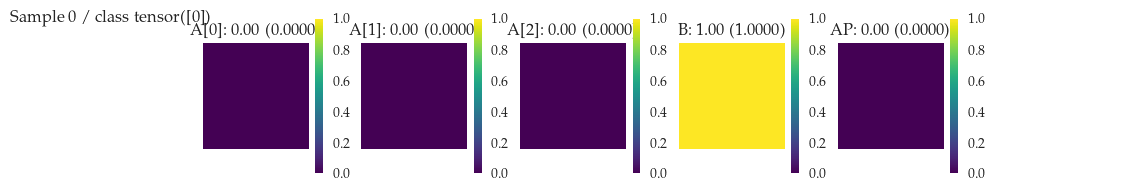

In [116]:
%autoreload
from utils import visualize_sensitivities

seed = 1

n = len(images)
# n = 10
# manual_sort = [
#     0, 7, 14, 21, 28,
#     2, 9, 16, 23, 30,
#     4, 11, 18, 25, 32,
#     6, 13, 20, 27, 34,
#     1, 8, 15, 22, 29,
#     3, 10, 17, 24, 31,
#     5, 12, 19, 26, 33,
# ]
sort = 'appearance'
visualize_sensitivities(models[0], seed, images, labels, ape=True, rpe=False, sort=sort, n=n, snr_signal=None)


#### SNR

In [79]:
%autoreload
from utils import visualize_sensitivities

# seed = 1

n = len(analysis_images)
# n = 10
# manual_sort = [
#     0, 7, 14, 21, 28,
#     2, 9, 16, 23, 30,
#     4, 11, 18, 25, 32,
#     6, 13, 20, 27, 34,
#     1, 8, 15, 22, 29,
#     3, 10, 17, 24, 31,
#     5, 12, 19, 26, 33,
# ]
sort = 'appearance'

snrs = []
for seed in seeds:
    snrs.append(visualize_sensitivities(models[seed], seed, analysis_images, analysis_labels, ape=True, rpe=True, sort=sort, n=n, snr_signal='appearance', only_snr=True))

snrs = np.array(snrs)
print(np.mean(snrs), np.std(snrs))


Image saliency SNR: 41.6383dB
Image saliency SNR: 41.4812dB
Image saliency SNR: 40.8945dB
Image saliency SNR: 41.3671dB
Image saliency SNR: 40.8666dB
Image saliency SNR: 40.8912dB
Image saliency SNR: 40.5793dB
Image saliency SNR: 40.9723dB
Image saliency SNR: 41.4958dB
Image saliency SNR: 40.9665dB
41.11527186687455 0.33262905946192


### No PE - fixed zero grad

In [75]:
%autoreload

# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_classes = 2
pos_emb = 'none'
use_rel_pos = False

# DEBUG
# seeds = range(2)
# n_epochs = 1000
# pos_emb = 'none'
# use_rel_pos = False

run_appearance(seeds, n_epochs, lr, d, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method='input_gradient_withnegative')

Epoch 0: 0.7221008539199829
Epoch 2000: 0.02107856422662735
Epoch 3999: 0.002895661862567067
Accuracy: 1.0
Epoch 0: 0.7210021018981934
Epoch 2000: 0.020834438502788544
Epoch 3999: 0.002863737754523754
Accuracy: 1.0
Epoch 0: 0.7215662598609924
Epoch 2000: 0.023010142147541046
Epoch 3999: 0.0030359893571585417
Accuracy: 1.0
Epoch 0: 1.0340348482131958
Epoch 2000: 0.03455383703112602
Epoch 3999: 0.004102038219571114
Accuracy: 1.0
Epoch 0: 0.7439739108085632
Epoch 2000: 0.024278920143842697
Epoch 3999: 0.003159926040098071
Accuracy: 1.0
Epoch 0: 0.9646301865577698
Epoch 2000: 0.027945375069975853
Epoch 3999: 0.003468348877504468
Accuracy: 1.0
Epoch 0: 0.7156517505645752
Epoch 2000: 0.020956415683031082
Epoch 3999: 0.002880038693547249
Accuracy: 1.0
Epoch 0: 0.6986721754074097
Epoch 2000: 0.02056218683719635
Epoch 3999: 0.0028406335040926933
Accuracy: 1.0
Epoch 0: 0.8546369075775146
Epoch 2000: 0.02559121698141098
Epoch 3999: 0.003306324128061533
Accuracy: 1.0
Epoch 0: 0.8437312841415405
Ep

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[TriViTal(
   (patch_layer): Conv2d(3, 1, kernel_size=(1, 1), stride=(1, 1))
   (block1): Block(
     (attention_norm): LayerNorm((1,), eps=1e-06, elementwise_affine=True)
     (ffn_norm): LayerNorm((1,), eps=1e-06, elementwise_affine=True)
     (ffn): Mlp(
       (fc1): Linear(in_features=1, out_features=1, bias=True)
       (fc2): Linear(in_features=1, out_features=1, bias=True)
       (dropout): Dropout(p=0.0, inplace=False)
     )
     (attn): Attention(
       (query): Linear(in_features=1, out_features=1, bias=True)
       (key): Linear(in_features=1, out_features=1, bias=True)
       (value): Linear(in_features=1, out_features=1, bias=True)
       (out): Linear(in_features=1, out_features=1, bias=True)
       (attn_dropout): Dropout(p=0.0, inplace=False)
       (proj_dropout): Dropout(p=0.0, inplace=False)
       (softmax): Softmax(dim=-1)
     )
   )
   (pool): AdaptiveAvgPool1d(output_size=[1])
   (flatten): Flatten(start_dim=1, end_dim=-1)
   (fc): Linear(in_features=1, out_f

### No PE - with negative

In [8]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_classes = 2
pos_emb = 'none'
use_rel_pos = False

# DEBUG
# seeds = range(2)
# n_epochs = 1000
# pos_emb = 'none'
# use_rel_pos = False

run_appearance(seeds, n_epochs, lr, d, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method='input_gradient_withnegative')

Epoch 0: 0.7221721410751343
Epoch 2000: 0.020952610298991203
Epoch 3999: 0.0028742330614477396
Accuracy: 1.0
Epoch 0: 0.7209873199462891
Epoch 2000: 0.020705854520201683
Epoch 3999: 0.002841782057657838
Accuracy: 1.0
Epoch 0: 0.7216449975967407
Epoch 2000: 0.02286934293806553
Epoch 3999: 0.00301276333630085
Accuracy: 1.0
Epoch 0: 1.0298912525177002
Epoch 2000: 0.03404203802347183
Epoch 3999: 0.004046170972287655
Accuracy: 1.0
Epoch 0: 0.7440201640129089
Epoch 2000: 0.024118997156620026
Epoch 3999: 0.0031348750926554203
Accuracy: 1.0
Epoch 0: 0.9656798839569092
Epoch 2000: 0.027722420170903206
Epoch 3999: 0.0034386622719466686
Accuracy: 1.0
Epoch 0: 0.7159914374351501
Epoch 2000: 0.02082267589867115
Epoch 3999: 0.002857532585039735
Accuracy: 1.0
Epoch 0: 0.6986644268035889
Epoch 2000: 0.02043575793504715
Epoch 3999: 0.0028189581353217363
Accuracy: 1.0
Epoch 0: 0.855926513671875
Epoch 2000: 0.0253989789634943
Epoch 3999: 0.0032788943499326706
Accuracy: 1.0
Epoch 0: 0.8437578082084656
Epo

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### No PE

In [8]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_classes = 2
pos_emb = 'none'
use_rel_pos = False

# DEBUG
# seeds = range(2)
# n_epochs = 1000
# pos_emb = 'none'
# use_rel_pos = False

run_appearance(seeds, n_epochs, lr, d, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n)

Epoch 0: 0.7221722602844238


Epoch 2000: 0.0209524966776371
Accuracy: 1.0
Epoch 0: 0.7209873199462891
Epoch 2000: 0.02070573717355728
Accuracy: 1.0
Epoch 0: 0.7216449975967407
Epoch 2000: 0.022870423272252083
Accuracy: 1.0
Epoch 0: 1.0298912525177002
Epoch 2000: 0.034043122082948685
Accuracy: 1.0
Epoch 0: 0.7440201640129089
Epoch 2000: 0.024119405075907707
Accuracy: 1.0
Epoch 0: 0.9656800627708435
Epoch 2000: 0.0277236457914114
Accuracy: 1.0
Epoch 0: 0.7159914374351501
Epoch 2000: 0.02082194574177265
Accuracy: 1.0
Epoch 0: 0.6986644268035889
Epoch 2000: 0.02043817564845085
Accuracy: 1.0
Epoch 0: 0.855926513671875
Epoch 2000: 0.02539939247071743
Accuracy: 1.0
Epoch 0: 0.8437576293945312
Epoch 2000: 0.030304046347737312
Accuracy: 1.0

Without bias:
appearance (all): 100.00 +- 0.00 (100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00)
appearance (c0) : 100.00 +- 0.00 (100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00)
appearance (c1) : 100.00 +- 0.00 (100.00, 10

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### APE - fix zero grad

In [76]:
%autoreload

# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_classes = 2
pos_emb = 'absolute'
use_rel_pos = False

run_appearance(seeds, n_epochs, lr, d, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method='input_gradient_withnegative')

Epoch 0: 0.6926138997077942
Epoch 2000: 0.020731210708618164
Epoch 3999: 0.0028638076037168503
Accuracy: 1.0


/home/robert-jan/surfdrive/experiments/vit-position-info/toy-experiments/../analysis/learned_relative_position.py:170: RuntimeWarning: Mean of empty slice.
  return sf.mean()
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 0: 0.7174707055091858
Epoch 2000: 0.02154436893761158
Epoch 3999: 0.002951663685962558
Accuracy: 1.0
Epoch 0: 0.7090640068054199
Epoch 2000: 0.02065981924533844
Epoch 3999: 0.002849587006494403
Accuracy: 1.0
Epoch 0: 0.8727425932884216
Epoch 2000: 0.030195966362953186
Epoch 3999: 0.0036527442280203104
Accuracy: 1.0
Epoch 0: 0.755929708480835
Epoch 2000: 0.027205418795347214
Epoch 3999: 0.003416389226913452
Accuracy: 1.0
Epoch 0: 0.7783785462379456
Epoch 2000: 0.021834706887602806
Epoch 3999: 0.0029628619085997343
Accuracy: 1.0
Epoch 0: 0.7028245329856873
Epoch 2000: 0.020998334512114525
Epoch 3999: 0.0028747646138072014
Accuracy: 1.0
Epoch 0: 0.714673638343811
Epoch 2000: 0.021592235192656517
Epoch 3999: 0.0029047438874840736
Accuracy: 1.0
Epoch 0: 0.7572290897369385
Epoch 2000: 0.026167424395680428
Epoch 3999: 0.003344058059155941
Accuracy: 1.0
Epoch 0: 0.8033183217048645
Epoch 2000: 0.02244761772453785
Epoch 3999: 0.00301438570022583
Accuracy: 1.0

Without bias:
appearance (all

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[TriViTal(
   (patch_layer): Conv2d(3, 1, kernel_size=(1, 1), stride=(1, 1))
   (block1): Block(
     (attention_norm): LayerNorm((1,), eps=1e-06, elementwise_affine=True)
     (ffn_norm): LayerNorm((1,), eps=1e-06, elementwise_affine=True)
     (ffn): Mlp(
       (fc1): Linear(in_features=1, out_features=1, bias=True)
       (fc2): Linear(in_features=1, out_features=1, bias=True)
       (dropout): Dropout(p=0.0, inplace=False)
     )
     (attn): Attention(
       (query): Linear(in_features=1, out_features=1, bias=True)
       (key): Linear(in_features=1, out_features=1, bias=True)
       (value): Linear(in_features=1, out_features=1, bias=True)
       (out): Linear(in_features=1, out_features=1, bias=True)
       (attn_dropout): Dropout(p=0.0, inplace=False)
       (proj_dropout): Dropout(p=0.0, inplace=False)
       (softmax): Softmax(dim=-1)
     )
   )
   (pool): AdaptiveAvgPool1d(output_size=[1])
   (flatten): Flatten(start_dim=1, end_dim=-1)
   (fc): Linear(in_features=1, out_f

### APE with negative

In [9]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_classes = 2
pos_emb = 'absolute'
use_rel_pos = False

run_appearance(seeds, n_epochs, lr, d, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method='input_gradient_withnegative')

Epoch 0: 0.6926035284996033
Epoch 2000: 0.020604902878403664
Epoch 3999: 0.002842067740857601
Accuracy: 1.0


/home/robert-jan/surfdrive/experiments/vit-position-info/toy-experiments/../analysis/learned_relative_position.py:170: RuntimeWarning: Mean of empty slice.
  return sf.mean()


Epoch 0: 0.7175094485282898
Epoch 2000: 0.021411597728729248
Epoch 3999: 0.0029293906409293413
Accuracy: 1.0
Epoch 0: 0.7090679407119751
Epoch 2000: 0.02053200639784336
Epoch 3999: 0.0028276669327169657
Accuracy: 1.0
Epoch 0: 0.8722123503684998
Epoch 2000: 0.029946614056825638
Epoch 3999: 0.0036165472120046616
Accuracy: 1.0
Epoch 0: 0.7557835578918457
Epoch 2000: 0.027009902521967888
Epoch 3999: 0.003388101700693369
Accuracy: 1.0
Epoch 0: 0.7782129645347595
Epoch 2000: 0.021694261580705643
Epoch 3999: 0.0029401599895209074
Accuracy: 1.0
Epoch 0: 0.7029451131820679
Epoch 2000: 0.020871955901384354
Epoch 3999: 0.002853160258382559
Accuracy: 1.0
Epoch 0: 0.7146598696708679
Epoch 2000: 0.021454351022839546
Epoch 3999: 0.002882399596273899
Accuracy: 1.0
Epoch 0: 0.7567547559738159
Epoch 2000: 0.02598174847662449
Epoch 3999: 0.003316637594252825
Accuracy: 1.0
Epoch 0: 0.8032578825950623
Epoch 2000: 0.02230069600045681
Epoch 3999: 0.002991217654198408
Accuracy: 1.0

Without bias:
appearance (

### APE

In [9]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_classes = 2
pos_emb = 'absolute'
use_rel_pos = False

run_appearance(seeds, n_epochs, lr, d, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n)

Epoch 0: 0.692603588104248


Epoch 2000: 0.020604804158210754
Accuracy: 1.0
Epoch 0: 0.7175095081329346
Epoch 2000: 0.0214115921407938
Accuracy: 1.0
Epoch 0: 0.7090680003166199
Epoch 2000: 0.020531801506876945
Accuracy: 1.0
Epoch 0: 0.872212290763855
Epoch 2000: 0.02994842268526554
Accuracy: 1.0
Epoch 0: 0.7557835578918457
Epoch 2000: 0.02700888365507126
Accuracy: 1.0
Epoch 0: 0.7782129645347595
Epoch 2000: 0.021694589406251907
Accuracy: 1.0
Epoch 0: 0.7029451131820679
Epoch 2000: 0.020871929824352264
Accuracy: 1.0
Epoch 0: 0.7146598100662231
Epoch 2000: 0.0214548259973526
Accuracy: 1.0
Epoch 0: 0.7567547559738159
Epoch 2000: 0.025981731712818146
Accuracy: 1.0
Epoch 0: 0.8032580614089966
Epoch 2000: 0.02230077236890793
Accuracy: 1.0

Without bias:
appearance (all): 84.03 +- 9.16 (72.98, 78.25, 94.72, 74.15, 99.88, 82.92, 84.33, 93.05, 72.76, 87.27)
appearance (c0) : 78.86 +- 7.80 (74.32, 77.86, 88.73, 71.88, 63.13, 83.83, 84.02, 85.28, 72.75, 86.82)
appearance (c1) : 95.50 +- 3.59 (97.80, 93.46, 94.15, 99.73, 99.8

### RPE - fix zero grad

In [78]:
%autoreload

# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_classes = 2
pos_emb = 'none'
use_rel_pos = True

# DEBUG
# n_epochs = 1000

run_appearance(seeds, n_epochs, lr, d, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method='input_gradient_withnegative')

Epoch 0: 0.6926027536392212
Epoch 2000: 0.0207512266933918
Epoch 3999: 0.002866663271561265
Accuracy: 1.0
Epoch 0: 0.9278618097305298
Epoch 2000: 0.0248568058013916
Epoch 3999: 0.003245915984734893
Accuracy: 1.0
Epoch 0: 1.2104240655899048
Epoch 2000: 0.037657011300325394
Epoch 3999: 0.0043170396238565445
Accuracy: 1.0
Epoch 0: 0.6976462006568909
Epoch 2000: 0.02112886868417263
Epoch 3999: 0.002885199850425124
Accuracy: 1.0
Epoch 0: 0.7913115620613098
Epoch 2000: 0.02754129096865654
Epoch 3999: 0.0034546973183751106
Accuracy: 1.0
Epoch 0: 0.7128941416740417
Epoch 2000: 0.02140103094279766
Epoch 3999: 0.002879682695493102
Accuracy: 1.0
Epoch 0: 0.7117297649383545
Epoch 2000: 0.020817551761865616
Epoch 3999: 0.0028600646182894707
Accuracy: 1.0
Epoch 0: 0.7011004090309143
Epoch 2000: 0.020352354273200035
Epoch 3999: 0.002792718820273876
Accuracy: 1.0
Epoch 0: 0.7098996043205261
Epoch 2000: 0.021050434559583664
Epoch 3999: 0.0028810626827180386
Accuracy: 1.0
Epoch 0: 1.1478917598724365
Epo

[TriViTal(
   (patch_layer): Conv2d(3, 1, kernel_size=(1, 1), stride=(1, 1))
   (block1): Block(
     (attention_norm): LayerNorm((1,), eps=1e-06, elementwise_affine=True)
     (ffn_norm): LayerNorm((1,), eps=1e-06, elementwise_affine=True)
     (ffn): Mlp(
       (fc1): Linear(in_features=1, out_features=1, bias=True)
       (fc2): Linear(in_features=1, out_features=1, bias=True)
       (dropout): Dropout(p=0.0, inplace=False)
     )
     (attn): Attention(
       (query): Linear(in_features=1, out_features=1, bias=True)
       (key): Linear(in_features=1, out_features=1, bias=True)
       (value): Linear(in_features=1, out_features=1, bias=True)
       (out): Linear(in_features=1, out_features=1, bias=True)
       (attn_dropout): Dropout(p=0.0, inplace=False)
       (proj_dropout): Dropout(p=0.0, inplace=False)
       (softmax): Softmax(dim=-1)
       (rel_pos): RelPosEmb2D(
         (emb_w): RelPosEmb1D()
         (emb_h): RelPosEmb1D()
       )
     )
   )
   (pool): AdaptiveAvgPoo

### RPE with negative

In [10]:
%autoreload

# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_classes = 2
pos_emb = 'none'
use_rel_pos = True

# DEBUG
# n_epochs = 1000

run_appearance(seeds, n_epochs, lr, d, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method='input_gradient_withnegative')

Epoch 0: 0.6925969123840332
Epoch 2000: 0.020624229684472084
Epoch 3999: 0.0028446349315345287
Accuracy: 1.0
Epoch 0: 0.9278261065483093
Epoch 2000: 0.02470528893172741
Epoch 3999: 0.003221086459234357
Accuracy: 1.0
Epoch 0: 1.2106820344924927
Epoch 2000: 0.037503279745578766
Epoch 3999: 0.004287607502192259
Accuracy: 1.0
Epoch 0: 0.6974081993103027
Epoch 2000: 0.020968405529856682
Epoch 3999: 0.002860670443624258
Accuracy: 1.0
Epoch 0: 0.7914978861808777
Epoch 2000: 0.027357861399650574
Epoch 3999: 0.0034279651008546352
Accuracy: 1.0
Epoch 0: 0.7127645611763
Epoch 2000: 0.02126195840537548
Epoch 3999: 0.002857315819710493
Accuracy: 1.0
Epoch 0: 0.7118509411811829
Epoch 2000: 0.020689690485596657
Epoch 3999: 0.0028384774923324585
Accuracy: 1.0
Epoch 0: 0.7010971307754517
Epoch 2000: 0.020218145102262497
Epoch 3999: 0.002770097926259041
Accuracy: 1.0
Epoch 0: 0.7099552154541016
Epoch 2000: 0.020913492888212204
Epoch 3999: 0.0028581267688423395
Accuracy: 1.0
Epoch 0: 1.1480817794799805
E

### RPE

In [10]:
%autoreload

# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_classes = 2
pos_emb = 'none'
use_rel_pos = True

# DEBUG
# n_epochs = 1000

run_appearance(seeds, n_epochs, lr, d, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n)

Epoch 0: 0.6925969123840332


Accuracy: 1.0
Epoch 0: 0.9278262257575989
Accuracy: 1.0
Epoch 0: 1.2106820344924927
Accuracy: 1.0
Epoch 0: 0.6974083185195923
Accuracy: 1.0
Epoch 0: 0.7914978861808777
Accuracy: 1.0
Epoch 0: 0.7127646803855896
Accuracy: 1.0
Epoch 0: 0.7118510603904724
Accuracy: 1.0
Epoch 0: 0.7010972499847412
Accuracy: 1.0
Epoch 0: 0.7099552750587463
Accuracy: 1.0
Epoch 0: 1.1480820178985596
Accuracy: 1.0

Without bias:
appearance (all): 100.00 +- 0.00 (100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00)
appearance (c0) : 100.00 +- 0.00 (100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00)
appearance (c1) : 100.00 +- 0.00 (100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00)
relative_position (all): 0.00 +- 0.00 (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00)
relative_position (c0) : 0.00 +- 0.00 (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00)
relative_position (c1) : 0.00 +- 0.00 (0.00, 0.00, 0.

### APE+RPE - fix zero grad

In [77]:
%autoreload

# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_classes = 2
pos_emb = 'absolute'
use_rel_pos = True

models = run_appearance(seeds, n_epochs, lr, d, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method='input_gradient_withnegative')

Epoch 0: 1.2760506868362427
Epoch 2000: 0.03443369269371033
Epoch 3999: 0.004104109015315771
Accuracy: 1.0


/home/robert-jan/surfdrive/experiments/vit-position-info/toy-experiments/../analysis/learned_relative_position.py:170: RuntimeWarning: Mean of empty slice.
  return sf.mean()
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 0: 0.8980551362037659
Epoch 2000: 0.02474125847220421
Epoch 3999: 0.003184032626450062
Accuracy: 1.0
Epoch 0: 0.7707328796386719
Epoch 2000: 0.023742320016026497
Epoch 3999: 0.00312598398886621
Accuracy: 1.0
Epoch 0: 0.8472079634666443
Epoch 2000: 0.029800014570355415
Epoch 3999: 0.0036563801113516092
Accuracy: 1.0
Epoch 0: 0.7198459506034851
Epoch 2000: 0.02296244353055954
Epoch 3999: 0.003032037988305092
Accuracy: 1.0
Epoch 0: 0.6915395259857178
Epoch 2000: 0.021110057830810547
Epoch 3999: 0.002914430806413293
Accuracy: 1.0
Epoch 0: 0.6995021104812622
Epoch 2000: 0.020926324650645256
Epoch 3999: 0.0028809222858399153
Accuracy: 1.0
Epoch 0: 0.7070560455322266
Epoch 2000: 0.02143772877752781
Epoch 3999: 0.002940355334430933
Accuracy: 1.0
Epoch 0: 0.8615553975105286
Epoch 2000: 0.029621915891766548
Epoch 3999: 0.0036309233400970697
Accuracy: 1.0
Epoch 0: 0.8794817924499512
Epoch 2000: 0.027587855234742165
Epoch 3999: 0.0034506693482398987
Accuracy: 1.0

Without bias:
appearance (a

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


#### SNR

In [ ]:
%autoreload
from utils import visualize_sensitivities

# seed = 1

n = len(analysis_images)
# n = 10
# manual_sort = [
#     0, 7, 14, 21, 28,
#     2, 9, 16, 23, 30,
#     4, 11, 18, 25, 32,
#     6, 13, 20, 27, 34,
#     1, 8, 15, 22, 29,
#     3, 10, 17, 24, 31,
#     5, 12, 19, 26, 33,
# ]
sort = 'appearance'

snrs = []
for seed in seeds:
    snrs.append(visualize_sensitivities(models[seed], seed, analysis_images, analysis_labels, ape=True, rpe=True, sort=sort, n=n, snr_signal='appearance', only_snr=True))

snrs = np.array(snrs)
print(np.mean(snrs), np.std(snrs))

### APE+RPE with negative

In [11]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_classes = 2
pos_emb = 'absolute'
use_rel_pos = True

run_appearance(seeds, n_epochs, lr, d, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method='input_gradient_withnegative')

Epoch 0: 1.2754610776901245
Epoch 2000: 0.03394591063261032
Epoch 3999: 0.0040551889687776566
Accuracy: 1.0
Epoch 0: 0.8981919288635254
Epoch 2000: 0.024572474882006645
Epoch 3999: 0.0031591576989740133
Accuracy: 1.0
Epoch 0: 0.7707257866859436
Epoch 2000: 0.02359362319111824
Epoch 3999: 0.0031020354945212603
Accuracy: 1.0
Epoch 0: 0.8461413383483887
Epoch 2000: 0.029515180736780167
Epoch 3999: 0.003620202885940671
Accuracy: 1.0
Epoch 0: 0.7197996377944946
Epoch 2000: 0.022811483591794968
Epoch 3999: 0.0030079949647188187
Accuracy: 1.0
Epoch 0: 0.6913833618164062
Epoch 2000: 0.020982343703508377
Epoch 3999: 0.0028926099184900522
Accuracy: 1.0
Epoch 0: 0.6992994546890259
Epoch 2000: 0.020786670967936516
Epoch 3999: 0.0028578918427228928
Accuracy: 1.0
Epoch 0: 0.7071033716201782
Epoch 2000: 0.02130769193172455
Epoch 3999: 0.0029183775186538696
Accuracy: 1.0
Epoch 0: 0.8632459044456482
Epoch 2000: 0.02952188439667225
Epoch 3999: 0.0036119315773248672
Accuracy: 1.0
Epoch 0: 0.8794789314270

### APE+RPE

In [11]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_classes = 2
pos_emb = 'absolute'
use_rel_pos = True

run_appearance(seeds, n_epochs, lr, d, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n)

Epoch 0: 1.2754610776901245
Epoch 2000: 0.033946048468351364
Accuracy: 1.0
Epoch 0: 0.8981919884681702
Epoch 2000: 0.024572603404521942
Accuracy: 1.0
Epoch 0: 0.7707258462905884
Epoch 2000: 0.023593934252858162
Accuracy: 1.0
Epoch 0: 0.8461412787437439
Epoch 2000: 0.029516253620386124
Accuracy: 1.0
Epoch 0: 0.7197996377944946
Epoch 2000: 0.022811444476246834
Accuracy: 1.0
Epoch 0: 0.691383421421051
Epoch 2000: 0.02098246105015278
Accuracy: 1.0
Epoch 0: 0.6992994546890259
Epoch 2000: 0.020786743611097336
Accuracy: 1.0
Epoch 0: 0.7071033716201782
Epoch 2000: 0.021307887509465218
Accuracy: 1.0
Epoch 0: 0.8632458448410034
Epoch 2000: 0.02952173724770546
Accuracy: 1.0
Epoch 0: 0.879478931427002
Epoch 2000: 0.027416177093982697
Accuracy: 1.0

Without bias:
appearance (all): 85.07 +- 11.08 (73.00, 94.00, 93.88, 71.10, 65.52, 82.96, 95.72, 84.76, 99.17, 90.59)
appearance (c0) : 78.12 +- 8.14 (73.22, 77.23, 90.03, 69.29, 63.57, 82.72, 82.96, 84.97, 71.05, 86.18)
appearance (c1) : 95.73 +- 3.22 